# Breakout Identification with Geometric Brownian Motion Modeling

### Overview

The goal of this project is to develop **two** models: 
- The first model will be used to **generate and track** several price paths dictated by *Geometric Brownian Motion*. This model will dynamically compute an expected price trajectory and its associated confidence intervals over a specified time horizon—either based on user-supplied fundamental targets (target price, time horizon, and confidence parameters) or derived from historical growth rates. In essence, it serves as a ***forward-looking benchmark*** that encapsulates the diffusion properties of asset prices.

- The second model will **leverage the GBM-generated paths** by comparing them with real-time market data and a suite of technical indicators. It will classify observed price movements into *three categories* (negative breakout, neutral, or positive breakout) based on significant deviations from the expected GBM trajectory. Implemented as a machine learning classifier (such as a random forest), this model aims to identify actionable breakout signals by detecting when the ***market price diverges meaningfully from its predicted path***, while taking into account both fundamental and technical factors.

### Part 1: GBM Modeling

In this section, we focus on modeling the evolution of asset prices using Geometric Brownian Motion (GBM). The GBM model provides a forward-looking framework to generate and track several potential price paths over a specified time horizon, capturing the diffusion characteristics observed in real market data.


**Key Objectives**

- Utilize the GBM formula to compute the median (expected) price path from a given starting price $S_0$ to a target price. The GBM model is defined as: 
$$
S(t) = S_0 \exp\left[(\mu - \frac{1}{2}\sigma^2)t + \sigma\sqrt{t}\,z\right]
$$
where $\mu$ us the drift, $\sigma$ is the volatility, and $z$ is a standard normal random variable. 

Incorporate User Inputs or Historical Data:
The model is designed to work in two modes:

1. **User-Specified Parameters:**

If provided, you can input your own target price, target time horizon, confidence level, and confidence interval. These inputs are used to calibrate $\mu$ and $\sigma$ such that the GBM path reaches the target price within the given confidence bounds.

2. **Data-Driven Estimation:**

If no target parameters are specified, the model estimates the growth rate and volatility based on historical price data (using metrics like log returns), thereby setting a default target price based on recent performance.

Alongside the median price path, we compute upper and lower confidence bounds. These intervals represent the range within which the price is statistically expected to fall, given the diffusion properties of the GBM model.

**Why GBM Modeling?**

The GBM framework serves as a dynamic benchmark for price evolution. Even though individual market events are discrete and noisy, the aggregated price dynamics tend to smooth out into a diffusive (random walk-like) process. See the following research paper: https://hal.science/hal-00621253v3/document 

By establishing an expected price path with confidence intervals, we can later identify significant deviations (breakouts) that might signal actionable opportunities.

In the upcoming code cells, we will:

1. Ingest historical price data (via Alpaca API CSV files).
2. Calibrate GBM parameters either from user-specified inputs or historical estimations.
3. Generate and visualize the GBM-based price paths along with their confidence intervals.

___

First, we need to set up our data. We will import the dataset for the asset we will be trading on and add columns which hold some common technical indicators. 

In [28]:
import pandas as pd
import talib
from datetime import datetime
import numpy as np

data = pd.read_csv('QQQ_2025-03-02_datasets/QQQ_train_data.csv')


# --- Feature Engineering ---

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Moving Averages
data['sma_20'] = talib.SMA(data['close'], timeperiod=20)
data['sma_50'] = talib.SMA(data['close'], timeperiod=50)
data['sma_200'] = talib.SMA(data['close'], timeperiod=200)
data['ema_20'] = talib.EMA(data['close'], timeperiod=20)

# MACD
macd, macd_signal, macd_hist = talib.MACD(data['close'])
data['macd'] = macd
data['macd_signal'] = macd_signal
data['macd_hist'] = macd_hist

# ADX - Trend Strength
data['adx'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)

# --- Momentum Indicators ---
# RSI
data['rsi'] = talib.RSI(data['close'], timeperiod=14)

# Stochastic Oscillator
data['slowk'], data['slowd'] = talib.STOCH(data['high'], data['low'], data['close'])

# CCI - Commodity Channel Index
data['cci'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)

# --- Volatility Indicators ---
# Bollinger Bands
upper, middle, lower = talib.BBANDS(data['close'], timeperiod=20)
data['bb_upper'] = upper
data['bb_middle'] = middle
data['bb_lower'] = lower
data['bb_width'] = (upper - lower) / middle  # Bollinger Band Width

# ATR - Average True Range
data['atr'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)

# --- Volume Indicators ---
# OBV - On-Balance Volume
data['obv'] = talib.OBV(data['close'], data['volume'])

# Volume Rate of Change
data['volume_roc'] = data['volume'].pct_change(5)

# --- Price Patterns ---
# Calculate price rate of change
data['price_roc'] = data['close'].pct_change(5)

# Daily Returns
data['daily_return'] = data['close'].pct_change()

# Intraday volatility (High-Low range)
data['intraday_vol'] = (data['high'] - data['low']) / data['close']

# Price distance from moving average
data['dist_from_sma20'] = (data['close'] - data['sma_20']) / data['sma_20']
data['dist_from_sma50'] = (data['close'] - data['sma_50']) / data['sma_50']

# Drop rows with NaN values (from the calculation of indicators)
data.dropna(inplace=True)

# Display the first few rows with indicators
data.head()

,volume,high,low,close,open,vwap,sma_20,sma_50,sma_200,ema_20,...,bb_lower,bb_width,atr,obv,volume_roc,price_roc,daily_return,intraday_vol,dist_from_sma20,dist_from_sma50
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-07 12:55:00+00:00,298961,445.57,445.210,445.410,445.310,445.424181,445.199495,443.302940,439.206934,445.042634,...,444.516952,0.003066,0.465728,3019441.0,-0.191709,-0.000067,0.000247,0.000808,0.000473,0.004753
2024-03-07 13:00:00+00:00,300770,445.50,445.210,445.485,445.405,445.312092,445.250745,443.455440,439.229359,445.084764,...,444.648839,0.002704,0.453176,3320211.0,-0.089721,0.000279,0.000168,0.000651,0.000526,0.004577
2024-03-07 13:05:00+00:00,221374,445.65,445.390,445.410,445.480,445.516744,445.275245,443.599240,439.258710,445.115739,...,444.689511,0.002631,0.439378,3098837.0,-0.196605,-0.000213,-0.000168,0.000584,0.000303,0.004082
2024-03-07 13:10:00+00:00,243248,445.62,445.050,445.550,445.420,445.342260,445.306245,443.755240,439.288060,445.157097,...,444.731354,0.002582,0.448708,3342085.0,-0.408415,0.000357,0.000314,0.001279,0.000547,0.004044
2024-03-07 13:15:00+00:00,280229,445.75,445.365,445.510,445.570,445.623364,445.351765,443.898438,439.318960,445.190707,...,444.871510,0.002157,0.444158,3061856.0,-0.007030,0.000472,-0.000090,0.000864,0.000355,0.003630


Before we continue, it is important to note that we want to have two scenarios to make our code easier for parallel usage. We should create a condition where we specify our own parameters, and another where this process is automated. 


### **A. User-Specified Parameters**
The user supplies:
- `target_price` (e.g., $8)
- `target_time_horizon` ***T*** (in years; 1 month = 1/12 year)
- `confidence_level` (e.g., 70% or 0.70)
- `confidence_interval` (in dollars, the half-width of the interval around the target)

Using these, we can “reverse engineer” the volatility (σ) and drift (μ) so that the median GBM path reaches the target and the final price falls within the confidence bounds with the given probability. Assuming the GBM model is:
$$
S(t) = S_0 \exp\left[(\mu - \frac{1}{2}\sigma^2)t + \sigma\sqrt{t}\,z\right]
$$

with $z$ ~ $N$(0,1) and noting that the median (with $z$ = 0) is 

$$
\text{Median} = S_0 \exp\left[(\mu - \frac{1}{2} \sigma^2)t\right]
$$

We set the median equal to the target price above (median). For the confidence interval, we assume that the relative interval is given by: 
$$ \text{Relative interval} = \frac{\text{confidence interval}}{P_{target}}$$

In a normal distribution, a symmetric confidence interval (in log-space) corresponds approximately to:
$$
2\Phi\left(\frac{I/P_{\text{target}}}{\sigma \sqrt{T}}\right) - 1 = \text{confidence level}
$$

where $I$ is the confidence interval in dollars and $\Phi$ is the cumulative distribution function of the standard normal distribution. We then solve for $\sigma$ as:
$$\sigma = \frac{I/P_{\text{target}}}{z \sqrt{T}}$$

And so:
$$z = \Phi^{-1}\left(\frac{\text{confidence level} + 1}{2}\right)$$

Once $\sigma$ is determined, we can solve for $\mu$ by rearranging the median equation: 
$$
\mu = \frac{\ln\left(\frac{P_{\text{target}}}{S_0}\right)}{T}  + \frac{1}{2} \sigma^2
$$




Let's implement this calibration: 

In [29]:
import numpy as np
from scipy.stats import norm

def calibrate_gbm(S0, target_price, T, confidence_level, confidence_interval):
    """
    Calibrate the GBM parameters based on user-specified inputs.
    
    Parameters:
      S0: Current price (float)
      target_price: Target price at time horizon T (float)
      T: Target time horizon in years (float)
      confidence_level: Confidence level as a decimal (e.g., 0.70 for 70%)
      confidence_interval: Half-width of the confidence interval in dollars (float)
      
    Returns:
      mu: Drift parameter (float)
      sigma: Volatility parameter (float)
      z: z-value corresponding to the confidence level (float)
    """
    # Calculate the relative interval in terms of the target price
    rel_interval = confidence_interval / target_price
    # Calculate the z-score for the given confidence level
    z = norm.ppf((confidence_level + 1) / 2)
    # Solve for sigma using the relationship derived above
    sigma = rel_interval / (z * np.sqrt(T))
    # Solve for mu using the median condition
    mu = (np.log(target_price / S0)) / T + 0.5 * sigma**2
    return mu, sigma, z


### **B. Estimating from Historical Data**
If the user does not provide the target parameters, we can estimate an annualized growth rate and volatility using the past year's log returns from historical price data. 

For instance, assuming our dataframe `data` contains a `'close'` column:

In [30]:
def estimate_growth_volatility(data):
    """
    Estimate the annualized growth rate and volatility from historical data.
    
    Parameters:
      data: Pandas DataFrame containing historical data with a 'close' column.
      
    Returns:
      mu_est: Estimated annualized drift (float)
      sigma_est: Estimated annualized volatility (float)
    """
    data = data.copy()
    # Compute log returns
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))
    # Drop missing values
    data = data.dropna(subset=['log_return'])
    
    intervals_per_day = 78
    trading_intervals = intervals_per_day * 252
    # Annualize the mean and standard deviation of log returns
    mu_est = data['log_return'].mean() * trading_intervals
    sigma_est = data['log_return'].std() * np.sqrt(trading_intervals)
    return mu_est, sigma_est

def default_target(S0, mu_est, T):
    """
    Compute a default target price based on the estimated drift.
    
    Parameters:
      S0: Current price (float)
      mu_est: Estimated annualized drift (float)
      T: Target time horizon in years (float)
      
    Returns:
      target_price: The default target price (float)
    """
    target_price = S0 * np.exp(mu_est * T)
    return target_price


**Constructing the Expected GBM Path**
Using the calibrated parameters, build the median (expected) path and the confidence intervals for any intermediate time $t$ (where $0 \le t \le T)$. For GBM, the median path is: 
$$S_{\text{median}}(t) = S_0  \exp\left((\mu - \frac{1}{2}\mu^2)t\right),$$
and the $z$-quantiles give the bounds: 
$$S_{\text{lower}}(t) = S_{\text{median}}(t) \cdot exp(-z\sigma\sqrt{t}),$$
$$S_{\text{upper}}(t) = S_{\text{median}}(t) \cdot exp(z\sigma\sqrt{t}),$$

In [31]:
def gbm_path(S0, mu, sigma, z, T, n_steps=100):
    t_array = np.linspace(0, T, n_steps)
    median_path = S0 * np.exp((mu - 0.5 * sigma**2) * t_array)
    lower_path = median_path * np.exp(-z * sigma * np.sqrt(t_array))
    upper_path = median_path * np.exp(z * sigma * np.sqrt(t_array))
    return t_array, median_path, lower_path, upper_path


**Calculating the Deviation and Labeling Breakouts**

At any given current time (say, using the latest price from your data), you can compute the expected median and confidence interval for that moment (based on the time elapsed since now to T). Then define a deviation metric; for example:
- Deviation = (Observed Price – Expected Median) / (Expected Median)
- Label as:
  - **1 (positive breakout)**: if the observed price exceeds the upper bound by a threshold
  - **–1 (negative breakout)**: if it is below the lower bound
  - **0 (neutral)**: otherwise

In [32]:
def label_breakout(current_price, S_median, S_lower, S_upper, threshold=0.01):
    # threshold: additional percentage deviation needed to call a breakout
    if current_price > S_upper * (1 + threshold):
        return 1
    elif current_price < S_lower * (1 - threshold):
        return -1
    else:
        return 0

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suppose 'data' is your DataFrame with historical data.
# For each timestamp, compute t (time to target) in years.
# For simplicity, assume we know the target time horizon T (in years).
T = 4/12  # e.g., 1 month expressed in years
# You could compute t_remaining = T - (current_time - start_time)

# For each row, calculate the GBM median and bounds.
# Here, we'll assume a fixed T and use the current price as S0.
# In practice, you'll want to update S0 to the price at the moment.
S0 = data['close'].iloc[0]

# Decide which calibration to use:
user_specified = True  # set to True if the user supplies target, etc.
if user_specified:
    # Replace these with user inputs
    target_price = 550.0
    confidence_level = 0.70
    confidence_interval = 15.0
    mu, sigma, z = calibrate_gbm(S0, target_price, T, confidence_level, confidence_interval)
else:
    mu_est, sigma_est = estimate_growth_volatility(data)
    mu, sigma = mu_est, sigma_est
    # Set default target as the median projected over T
    target_price = default_target(S0, mu, T)
    # Set z corresponding to a default confidence level, e.g., 70%
    confidence_level = 0.70
    z = norm.ppf((confidence_level + 1) / 2)

# Create GBM path features for each row.
# Since timestamp is the index, we need to use the index
# We'll assume 't_elapsed' is measured in years from the first timestamp.
data['t_elapsed'] = (data.index - data.index[0]).total_seconds() / (365*24*3600)
# Clip t_elapsed to be <= T
data['t_elapsed'] = data['t_elapsed'].clip(upper=T)

# Compute the GBM expected median and bounds for each row:
data['GBM_median'] = S0 * np.exp((mu - 0.5 * sigma**2) * data['t_elapsed'])
data['GBM_lower'] = data['GBM_median'] * np.exp(-z * sigma * np.sqrt(data['t_elapsed']))
data['GBM_upper'] = data['GBM_median'] * np.exp(z * sigma * np.sqrt(data['t_elapsed']))

# Calculate deviation metric, e.g.:
data['deviation'] = (data['close'] - data['GBM_median']) / data['GBM_median']

# Label the breakout: you might set a threshold, say 1% extra deviation.
threshold = 0.01
data['breakout_label'] = data.apply(lambda row: label_breakout(row['close'], row['GBM_median'], row['GBM_lower'], row['GBM_upper'], threshold), axis=1)

# Now, select features for your RF model.
# You can include your technical indicators plus the deviation metric.
feature_cols = ['deviation', 'vwap', 'volume', 'open', 'high', 'low']  # extend as needed
X = data[feature_cols]
y = data['breakout_label']

# Split into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      3129
           0       0.97      1.00      0.99       117

    accuracy                           1.00      3246
   macro avg       0.99      1.00      0.99      3246
weighted avg       1.00      1.00      1.00      3246



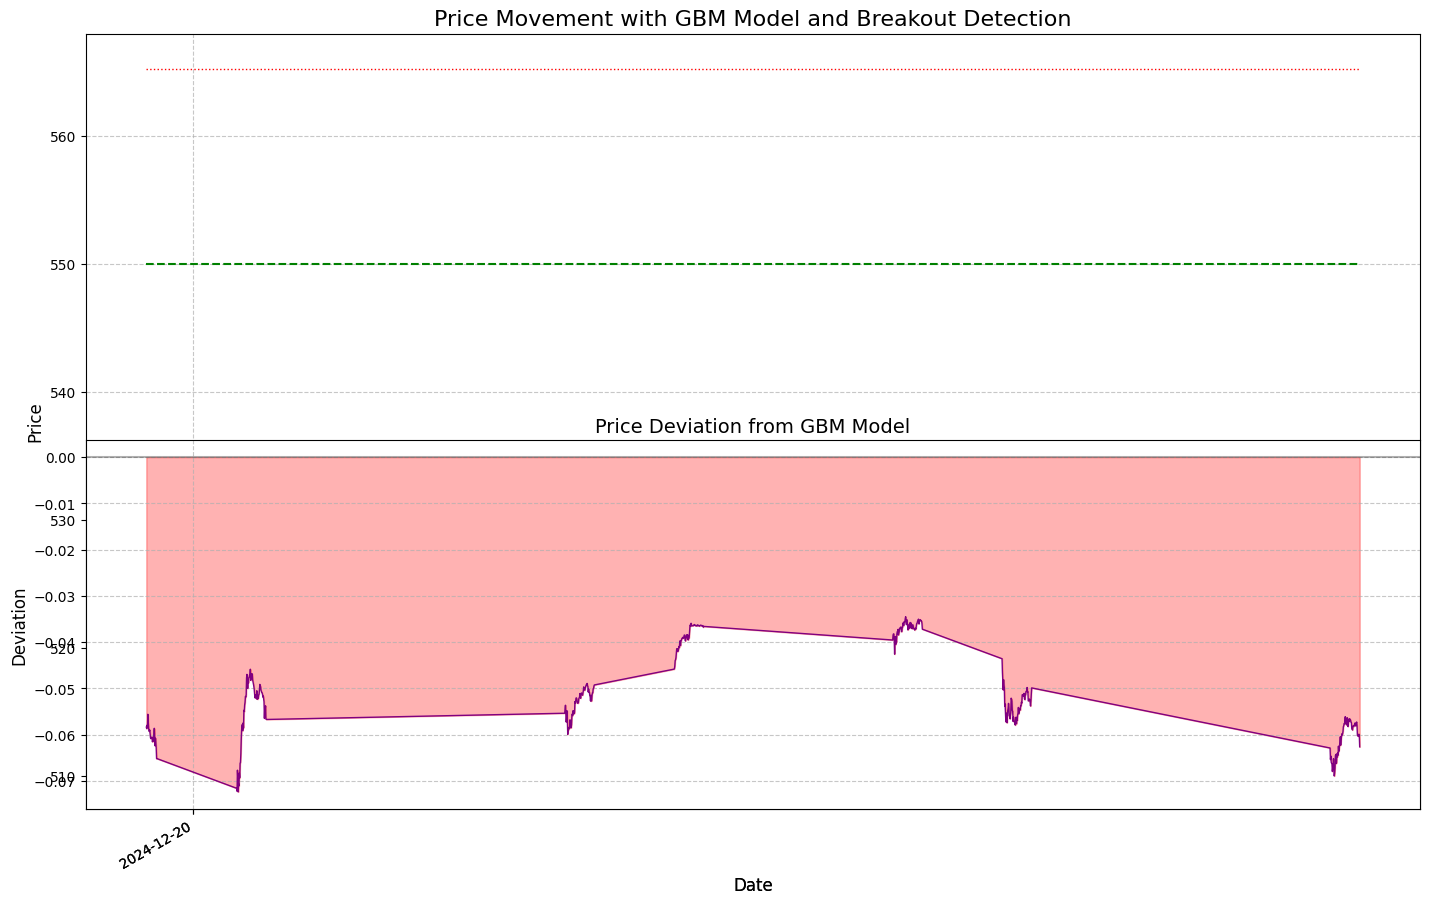

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure
plt.figure(figsize=(15, 10))

# Select a sample of the data (last 100 points for better visibility)
sample_data = data.iloc[-500:].copy()

# Plot the actual price
plt.plot(sample_data.index, sample_data['close'], color='blue', linewidth=1.5, label='Actual Price')

# Plot the GBM median path and confidence intervals
plt.plot(sample_data.index, sample_data['GBM_median'], color='green', linestyle='--', linewidth=1.5, label='GBM Median')
plt.plot(sample_data.index, sample_data['GBM_upper'], color='red', linestyle=':', linewidth=1, label='GBM Upper Bound')
plt.plot(sample_data.index, sample_data['GBM_lower'], color='red', linestyle=':', linewidth=1, label='GBM Lower Bound')

# Highlight breakout areas
breakout_positive = sample_data[sample_data['breakout_label'] == 1]
breakout_negative = sample_data[sample_data['breakout_label'] == -1]

# Scatter plot for positive breakouts
if not breakout_positive.empty:
    plt.scatter(breakout_positive.index, breakout_positive['close'], 
                color='green', s=50, marker='^', label='Positive Breakout')

# Scatter plot for negative breakouts
if not breakout_negative.empty:
    plt.scatter(breakout_negative.index, breakout_negative['close'], 
                color='red', s=50, marker='v', label='Negative Breakout')

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gcf().autofmt_xdate()

# Add labels and title
plt.title('Price Movement with GBM Model and Breakout Detection', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add deviation indicator as a subplot
plt.subplot(212)
plt.plot(sample_data.index, sample_data['deviation'], color='purple', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(sample_data.index, 
                 np.zeros_like(sample_data['deviation']), 
                 sample_data['deviation'], 
                 where=(sample_data['deviation'] > 0), 
                 color='green', alpha=0.3)
plt.fill_between(sample_data.index, 
                 np.zeros_like(sample_data['deviation']), 
                 sample_data['deviation'], 
                 where=(sample_data['deviation'] < 0), 
                 color='red', alpha=0.3)

# Format the x-axis to match the main plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gcf().autofmt_xdate()

plt.title('Price Deviation from GBM Model', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Deviation', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()